In [55]:
import pandas as pd

bench = 'nb301'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10'

In [56]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [57]:
from zc_combine.fixes.operations import get_ops_nb301

ops = ['out', *get_ops_nb301()]
ops

['out',
 'max_pool_3x3',
 'avg_pool_3x3',
 'skip_connect',
 'sep_conv_3x3',
 'sep_conv_5x5',
 'dil_conv_3x3',
 'dil_conv_5x5']

In [58]:
data['sep_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_4' in c or '_5' in c)]].sum(axis=1)
data['dil_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_6' in c or '_7' in c)]].sum(axis=1)
data['#convs'] = data['sep_convs'] + data['dil_convs']
data['#convs']

/tmp/ipykernel_19484/1961143760.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['sep_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_4' in c or '_5' in c)]].sum(axis=1)
/tmp/ipykernel_19484/1961143760.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['dil_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_6' in c or '_7' in c)]].sum(axis=1)
/tmp/ipykernel_19484/1961143760.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

0        10
1        10
2         7
3         7
4         7
         ..
11216    13
11217    12
11218     8
11219     8
11220    10
Name: #convs, Length: 11221, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

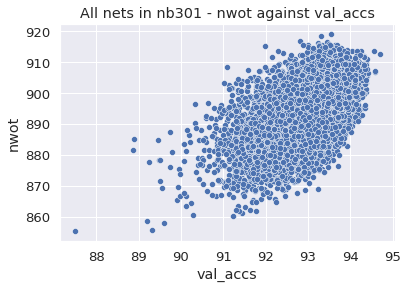

In [24]:
n_palette = len(data['n_convs'].unique())

sns.set(font_scale=1.2)

plt.figure()
sns.scatterplot(data=data, y='nwot', x=y)
plt.title(f'All nets in {bench} - nwot against val_accs')
plt.savefig(f'{bench}_nwot.png')
plt.show()

/tmp/ipykernel_18534/3122051377.py:2: UserWarning: 
The palette list has fewer values (10) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=data[data['nwot'] > 0], y='nwot', x=y, hue=data['n_convs'], palette=sns.color_palette()[:n_palette])


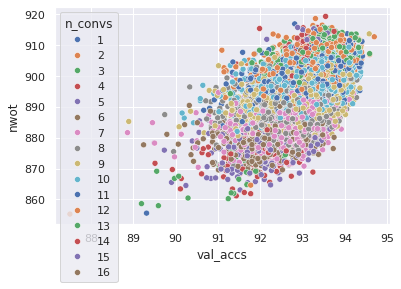

In [58]:
plt.figure()
sns.scatterplot(data=data[data['nwot'] > 0], y='nwot', x=y, hue=data['n_convs'], palette=sns.color_palette()[:n_palette])
plt.show()

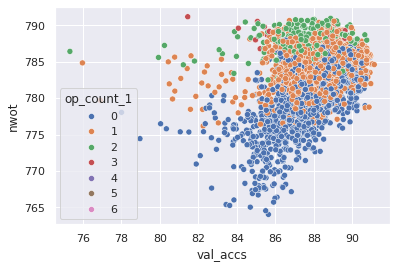

In [44]:
plt.figure()
sns.scatterplot(data=data[(data['nwot'] > 0) & (data['n_convs'] == 3)], y='nwot', x=y, hue=data['op_count_1'], palette=sns.color_palette()[:n_palette])
plt.show()

In [59]:
proxies = [c for c in data.columns if 'op_' not in c and '(' not in c and c not in ['net', '#convs', 'dil_convs', 'sep_convs', 'n_convs']]
print(proxies)

['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']


In [60]:
import scipy.stats
import pandas as pd


compute_tau = False
res_corrs = []

def get_corr(d):
    return {k: func(d[k], y[d.index])[0] for k in proxies}


for nc in sorted(data['#convs'].unique()):
    if 3 > nc or nc > 15:
        continue
    
    filtnets = data[data['#convs'] == nc]
    
    func = scipy.stats.kendalltau if compute_tau else scipy.stats.spearmanr
    
    res = get_corr(filtnets)
    res = {'#convs': nc, **res}
    res_corrs.append(res)
    
res_all = get_corr(data)
res_all = {'#convs': 'all', **res_all}
res_corrs.append(res_all)

df = pd.DataFrame(res_corrs)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
#convs,3,4,5,6,7,8,9,10,11,12,13,14,15,all
epe_nas,0.087521,0.075115,0.049025,0.045022,-0.004158,0.003343,0.023473,0.010638,0.00841,-0.003337,0.066975,-0.128073,-0.061318,0.001997
fisher,-0.532468,-0.311632,-0.418029,-0.399622,-0.352712,-0.30465,-0.319119,-0.216837,-0.227589,-0.192447,-0.182176,-0.038968,-0.226136,-0.272209
flops,0.457933,0.193386,0.324837,0.344413,0.315313,0.276095,0.277605,0.243282,0.22961,0.22621,0.260934,0.206934,0.035225,0.421585
grad_norm,-0.597967,-0.252871,-0.254199,-0.196395,-0.192604,-0.178089,-0.221699,-0.141266,-0.166522,-0.143838,-0.139691,-0.03258,-0.112198,-0.034796
grasp,0.605872,0.126488,0.364475,0.317405,0.340117,0.332352,0.281455,0.225879,0.232424,0.234482,0.099016,0.173083,-0.306154,0.340342
jacov,0.113495,0.174825,0.211127,0.111234,0.081228,0.047057,0.043721,0.023958,0.048686,0.051799,0.063849,0.033427,0.200043,-0.058144
l2_norm,0.621683,0.23565,0.391803,0.399447,0.380506,0.335325,0.338119,0.302235,0.293124,0.284699,0.311566,0.280074,0.07132,0.456629
nwot,0.585545,0.30452,0.423347,0.396042,0.408032,0.363227,0.36157,0.320528,0.307907,0.346457,0.38912,0.297879,-0.035225,0.472931
params,0.595709,0.270354,0.394891,0.40861,0.384333,0.343005,0.342889,0.309642,0.299747,0.287436,0.32847,0.270841,0.002174,0.458808


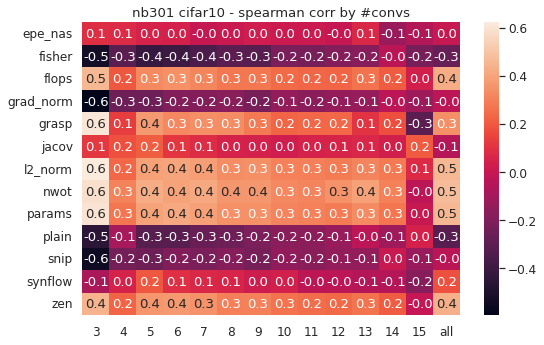

In [62]:
heatdf = df.T
heatdf.rename(columns=heatdf.iloc[0], inplace=True)
heatdf.drop(heatdf.index[0], inplace=True)

sns.set(font_scale=1.1)

plt.figure(figsize=(8, 5))
sns.heatmap(data=heatdf.astype(float), annot=True, fmt=".1f")
plt.title(f'{bench} {dataset} - spearman corr by #convs')
plt.tight_layout()
plt.savefig(f'figs/heat_{bench}.png')
plt.show()

In [56]:
func(data['nwot'], data['params'])

SignificanceResult(statistic=0.9532098755757871, pvalue=0.0)

In [50]:
func(data['sep_convs'], y)

SignificanceResult(statistic=0.4591490569157682, pvalue=0.0)

/tmp/ipykernel_19484/3645400213.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data, y='sep_convs', x=y, palette=sns.color_palette()[:n_palette])


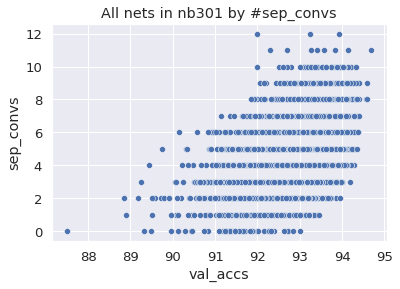

In [23]:
plt.figure()
sns.scatterplot(data=data, y='sep_convs', x=y, palette=sns.color_palette()[:n_palette])
plt.title(f'All nets in {bench} by #sep_convs')
plt.savefig(f'{bench}_sepconvs.png')
plt.show()